In [26]:
# Force compatible NumPy <2 and reinstall ultralytics + opencv
!pip install -q "numpy<2" opencv-python-headless==4.7.0.72 ultralytics --upgrade --force-reinstall


In [27]:
import torch, numpy as np, cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("torch:", torch.__version__, "cuda available:", torch.cuda.is_available())
print("numpy:", np.__version__)
print("cv2:", cv2.__version__)

model = YOLO("yolov8n.pt")
print("YOLOv8 model loaded:", type(model))

torch: 2.2.2 cuda available: False
numpy: 1.26.4
cv2: 4.11.0
YOLOv8 model loaded: <class 'ultralytics.models.yolo.model.YOLO'>


In [28]:
image_path = './sub-001.jpg'

/var/folders/k9/q0p5_p4s46q2lxnn596xb31h0000gn/T/ipykernel_76625/1072725843.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for b in preds.boxes if int(b.cls.cpu().numpy()) == 0]
/var/folders/k9/q0p5_p4s46q2lxnn596xb31h0000gn/T/ipykernel_76625/1072725843.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(b.conf.cpu().numpy()))


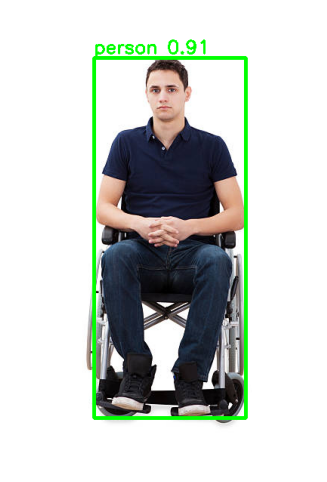

In [29]:
# read image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
H, W = img.shape[:2]

# predict
preds = model.predict(source=img, imgsz=640, conf=0.3, verbose=False)[0]

# get person boxes (COCO class 0)
person_boxes = [(int(b.xyxy[0][0]), int(b.xyxy[0][1]),
                 int(b.xyxy[0][2]), int(b.xyxy[0][3]),
                 float(b.conf.cpu().numpy()))
                for b in preds.boxes if int(b.cls.cpu().numpy()) == 0]

if not person_boxes:
    raise RuntimeError("No person detected!")

# pick highest-confidence person
x1, y1, x2, y2, conf = max(person_boxes, key=lambda b: b[4])

# draw bbox on image
img_bbox = img_rgb.copy()
cv2.rectangle(img_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
cv2.putText(img_bbox, f"person {conf:.2f}", (x1, max(20, y1-6)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# display
plt.figure(figsize=(8,6))
plt.imshow(img_bbox)
plt.axis('off')
plt.show()


In [35]:
!wget -O sam_vit_h.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
SAM_CHECKPOINT = './sam_vit_h.pth'


--2025-09-23 09:54:30--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.164.92.58, 3.164.92.87, 3.164.92.54, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.164.92.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h.pth’

sam_vit_h.pth       100%[===================>]   2.39G  97.0MB/s    in 26s     

2025-09-23 09:54:57 (92.4 MB/s) - ‘sam_vit_h.pth’ saved [2564550879/2564550879]



In [36]:
# Install SAM from GitHub
!pip install git+https://github.com/facebookresearch/segment-anything.git


  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/k9/q0p5_p4s46q2lxnn596xb31h0000gn/T/pip-req-build-pz64j_15
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/k9/q0p5_p4s46q2lxnn596xb31h0000gn/T/pip-req-build-pz64j_15
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


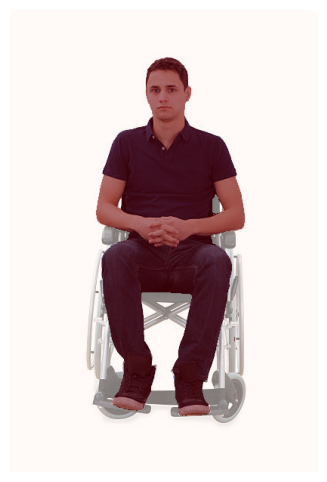

In [37]:
# path to checkpoint downloaded above
from segment_anything import SamPredictor, sam_model_registry
SAM_CHECKPOINT = './sam_vit_h.pth'
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT).to(DEVICE)

# SAM predictor
predictor = SamPredictor(sam)

# image from yolo
predictor.set_image(img_rgb)

# use the bounding box prediction from YOLO as the input for SAM
box = np.array([x1, y1, x2, y2]) 

# only output 1 mask per bounding box
masks, scores, logits = predictor.predict(box=box[None, :], multimask_output=False)

# final mask
person_mask = masks[0]

# visualize overlayed mask on image
plt.figure(figsize=(8,6))
plt.imshow(img_rgb)
plt.imshow(person_mask, alpha=0.5, cmap='Reds')
plt.axis('off')
plt.show()